In [1]:
# Importing Libraries
import pandas as pd
import glob
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
import matplotlib.pyplot as plt

In [2]:
# Load the first 100 positive review text files
pos_review = (glob.glob(r"...\pos\*.txt"))[0:100]

In [3]:
# Read each file and append its content to a list
lines_pos = []
for i in pos_review:
    try:
        f = open(i, 'r')
        temp = f.readlines()[0]
        lines_pos.append(temp)
        f.close()
    except Exception as e:
        continue

In [5]:
# Tokenizer to extract words
tokenizer = RegexpTokenizer('[\w]+')

In [6]:
# Load English stopwords
stop_words = stopwords.words('english')

### TF-IDF Vectorization

**TF-IDF** stands for Term Frequency-Inverse Document Frequency.

In [7]:
# Initialize the TF-IDF Vectorizer, telling it to use our stop_words list
vec = TfidfVectorizer(stop_words=stop_words)

In [8]:
# Learn the vocabulary and create the TF-IDF matrix from our reviews
vector_lines_pos = vec.fit_transform(lines_pos)

**vec.fit_transform**: 
- creates a matrix where each row represents a document (review) and each column represents a word.
- The value in each cell is the TF-IDF score for that word in that document.

In [9]:
vector_lines_pos

<100x4001 sparse matrix of type '<class 'numpy.float64'>'
	with 9893 stored elements in Compressed Sparse Row format>

### Calculating Word Similarity

To find how similar words are, we first need to change the matrix's orientation.

In [10]:
# Convert the sparse matrix to a full (dense) numpy array
A = vector_lines_pos.toarray()

In [11]:
A.shape

(100, 4001)

In [12]:
# Transpose the matrix
A = A.transpose()

In [13]:
A.shape

(4001, 100)

The original matrix (A) was **(documents x words)**. The new, transposed matrix (A.transpose()) is **(words x documents)**.

### Calculating Cosine Similarity

In [14]:
# Convert the dense array back to a sparse matrix for efficient calculation
A_sparse = sparse.csr_matrix(A)

In [15]:
# Calculate cosine similarity between all word vectors
similarities_sparse = cosine_similarity(A_sparse, dense_output=False)

In [16]:
# word-similarity matrix
similarities_sparse

<4001x4001 sparse matrix of type '<class 'numpy.float64'>'
	with 1331177 stored elements in Compressed Sparse Row format>

In [17]:
# Convert to a Dictionary of Keys (DOK) to inspect values
list(similarities_sparse.todok().items())[35000:35010]

[((108, 1469), 0.37803585968894826),
 ((108, 1470), 0.21896854347467395),
 ((108, 1476), 0.06407477897013802),
 ((108, 1477), 0.1851895775142377),
 ((108, 1480), 0.2011103687616941),
 ((108, 1489), 0.06995711757772093),
 ((108, 1496), 0.10714874067068894),
 ((108, 1503), 0.3048733383009192),
 ((108, 1504), 0.3048733383009192),
 ((108, 1512), 0.3048733383009192)]

This means the word at index 108 and the word at index 1469 have a cosine similarity score of 0.378.

In [18]:
# Convert the similarity matrix into a readable table (DataFrame).
df=pd.DataFrame(list(similarities_sparse.todok().items()),columns=["words","weight"])

# Sort the table to put the most similar word pairs at the top.
df=df.sort_values(by=['weight'],ascending=False)

# Remove pairs of the exact same word (which have a similarity of 1.0).
df=df.loc[np.round(df['weight']) < 1]

# Clean up the row numbers (index) after sorting and filtering.
df=df.reset_index(drop=True)

In [19]:
df.head(15)

,words,weight
0,"(3372, 3971)",0.499961
1,"(3971, 3372)",0.499961
2,"(1192, 2554)",0.499958
3,"(2554, 1192)",0.499958
4,"(1321, 2468)",0.499957
5,"(2468, 710)",0.499957
6,"(710, 2468)",0.499957
7,"(2468, 1321)",0.499957
8,"(2146, 889)",0.499909
9,"(889, 2146)",0.499909


### Network Visualization

In [20]:
# Import libraries for graph creation and visualization
import networkx as nx
import matplotlib.pyplot as plt

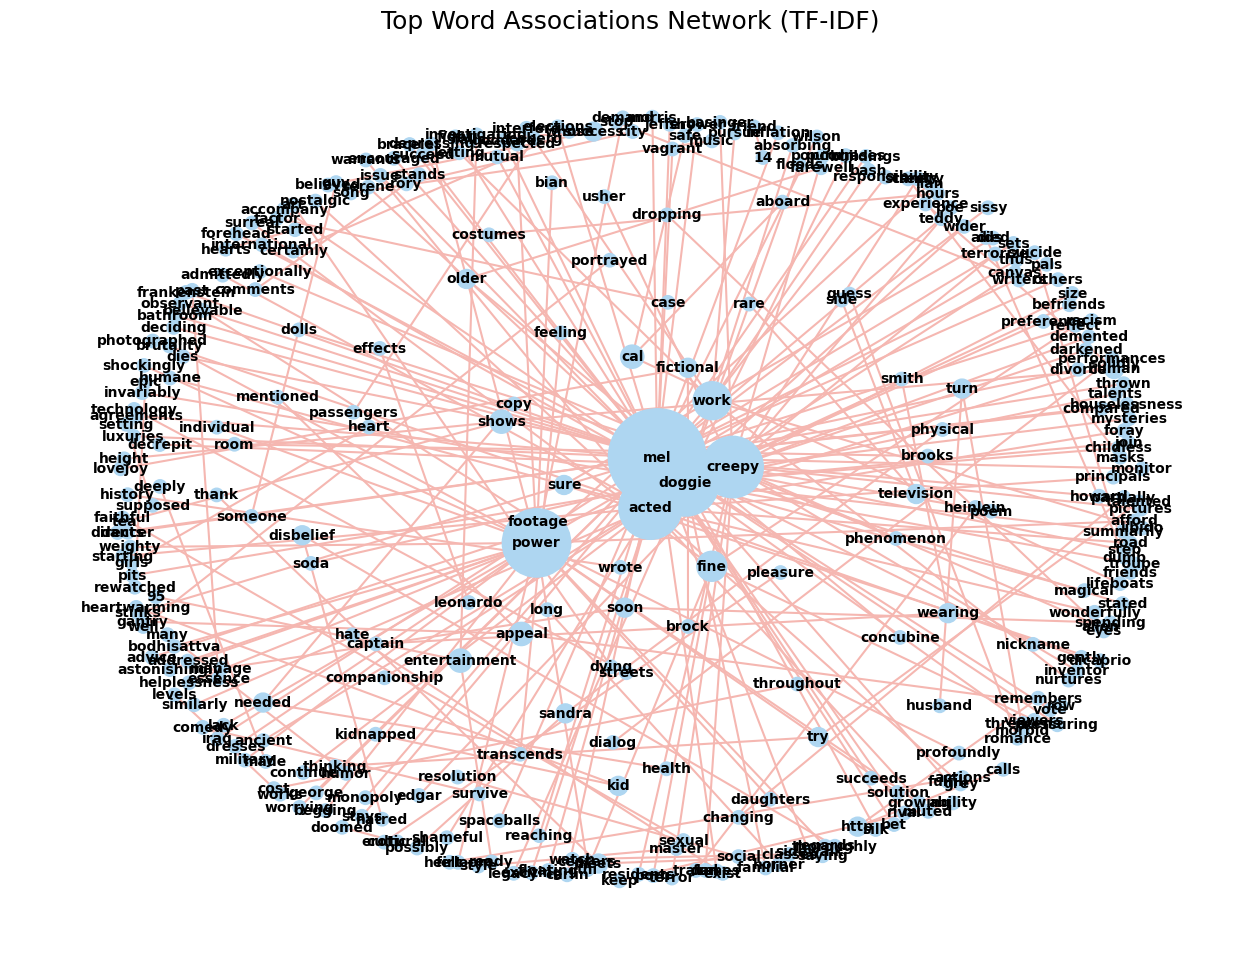

In [21]:
# Create a mapping from index to word.
idx2word = vec.get_feature_names_out()

# Select the top N pairs to visualize.
top_n = 500
df_top = df.head(top_n)

# Create an empty graph.
G = nx.Graph()

# Add the top N word pairs as edges.
for index, row in df_top.iterrows():
    word1_idx, word2_idx = row['words']
    word1 = idx2word[word1_idx]
    word2 = idx2word[word2_idx]
    G.add_edge(word1, word2, weight=row['weight'])

# Set node positions.
pos = nx.spring_layout(G, k=0.9, iterations=100, seed=42)

# Set node sizes based on connections.
degree_centrality = nx.degree_centrality(G)
node_size = [v * 30000 for v in degree_centrality.values()]

# Create a list of edge widths from the 'weight' column.
# Multiplying by a factor makes the differences more visible.
edge_weights = [G.edges[u, v]['weight'] * 3 for u, v in G.edges()]

# Draw the graph using the weights for the edge widths.
plt.figure(figsize=(16, 12))
nx.draw_networkx(
    G,
    pos,
    with_labels=True,
    node_size=node_size,
    node_color="#AED6F1",
    edge_color="#F5B7B1",
    width=edge_weights,  # This now uses the cosine similarity score
    font_size=10,
    font_weight="bold"
)
plt.title("Top Word Associations Network (TF-IDF)", fontsize=18)
plt.axis("off")
plt.show()